# pydentate Tutorial 1: Graph Neural Networks for Predicting Metal–Ligand Coordination of Transition Metal Complexes

The following tutorial serves as an introduction to pydentate, an open-source Python package for predicting metal-ligand coordination and generating 3D structures of transition metal complexes from only SMILES string inputs.

This tutorial demonstrates how to predict coordination number and coordinating atom indices from SMILES inputs. For illustrative purposes, a subset of the holdout data from the original paper is used here, which users should replace with their own datasets. Future tutorials will cover structure generation and hemilability prediction.

For a detailed explanation of pydentate, please refer to ["Graph neural networks for predicting metal–ligand coordination of transition metal complexes"](https://doi.org/10.26434/chemrxiv-2024-nzk5q).

If you find this work useful, please consider citing the associated publication:
J. W. Toney, R. G. St. Michel, A. G. Garrison, I. Kevlishvili, H. J. Kulik, ChemRxiv 2024, 10.26434/chemrxiv-2024-nzk5q

### Step 0: Preliminaries
pydentate uses graph neural networks to predict metal-ligand coordination. Specifically, the directed message passing neural network (D-MPNN) architecture is used to learn an optimal molecular representation, which is then passed through a feed forward network (FFN) for final property prediction. Before message passing, an initial molecular representation is required, which the D-MPNN model iteratively improves upon. This initial representation is defined using basic atomic (e.g., atomic number, formal charge, etc.) and bond (e.g., bond order, aromaticity, etc.) descriptors. These descriptors are encoded automatically with RDKit. The initial representation is refined by passing updates along nodes (i.e., atoms) and edges (i.e., bonds) in the molecular graph. Because SMILES strings fully encode connectivity, the provided SMILES strings may be used to construct a molecular graph representing each molecule. This graph is then updated via message passing steps. After learning an optimal representation for each molecule through message passing, this "learned representation" is passed as an input to an FFN for final property prediction.

### Step 1: Predicting coordination from SMILES
The trained machine learning models available in pydentate may be conveniently loaded to predict metal-ligand coordination from SMILES inputs. The two properties predicted in this tutorial are "coordination number" and "coordinating atoms". Coordination number is a molecular property, and refers to the number of bonds a ligand forms with a metal, and is closely related to the more well-known concepts of denticity (i.e., the number of discontinuous atoms which bind to a metal, such as in the bidentate bipyridine ligand) and hapticity (i.e., the number of continuous atoms which bind to a metal, such as in the monodentate haptic cyclopentadiene ligand). Coordinating atoms are atom-level properties, and indicate whether or not a given atom in a ligand directly binds to a metal.

In [1]:
# import the predict module
from pydentate import predict

# predict coordination number
task = 'coordination_number'
predict.make_predictions(input_path='example_ligands.csv', task=task, smiles_column='smiles', output_path='coordination_number_preds.csv')

# predict coordinating atoms
task = 'coordinating_atoms'
predict.make_predictions(input_path='example_ligands.csv', task=task, smiles_column='smiles', output_path='coordinating_atoms_preds.csv')

Loading training args
Loading pretrained parameter: encoder.encoder.0.W_i.weight
Loading pretrained parameter: encoder.encoder.0.W_h.weight
Loading pretrained parameter: encoder.encoder.0.W_o.weight
Loading pretrained parameter: encoder.encoder.0.W_o.bias
Loading pretrained parameter: readout.1.weight
Loading pretrained parameter: readout.1.bias
Loading pretrained parameter: readout.4.weight
Loading pretrained parameter: readout.4.bias
Loading pretrained parameter: readout.7.weight
Loading pretrained parameter: readout.7.bias


99it [00:00, 298.39it/s]


Saving predictions to coordination_number_preds.csv
Done predicting coordination_number!
Loading training args
Loading pretrained parameter: encoder.encoder.0.W_i.weight
Loading pretrained parameter: encoder.encoder.0.W_h.weight
Loading pretrained parameter: encoder.encoder.0.W_o.weight
Loading pretrained parameter: encoder.encoder.0.W_o.bias
Loading pretrained parameter: readout.ffn_list.0.ffn.0.1.weight
Loading pretrained parameter: readout.ffn_list.0.ffn.0.1.bias
Loading pretrained parameter: readout.ffn_list.0.ffn.0.4.weight
Loading pretrained parameter: readout.ffn_list.0.ffn.0.4.bias
Loading pretrained parameter: readout.ffn_list.0.ffn_readout.1.weight
Loading pretrained parameter: readout.ffn_list.0.ffn_readout.1.bias


99it [00:00, 253.38it/s]

Saving predictions to coordinating_atoms_preds.csv
Done predicting coordinating_atoms!


### Step 2: Processing predictions
Probabilities of predicted coordination number and coordinating atoms are saved to 'coordination_number_preds.csv' and 'coordinating_atom_preds.csv'. For each ligand in 'coordination_number_preds.csv', six probabilities are stored corresponding to the predicted probability of the ligand to exhibit a coordination number of 1, 2, 3, 4, 5, or 6. Similarly, 'coordinating_atom_preds.csv' contains a length $N$ list (where $N$ is the number of heavy atoms in each ligand) of predicted probabilities that each atom is a coordinating atom.

For use in downstream workflows, these predictions must be processed into a useable format. The coordination number probabilities are processed by returning the index corresponding to the maximum probability. The coordinating atom probabilities are processed by rounding the predictions, returning the indices of all probabilities greater than 0.5. Both lists are indexed starting with zero.

For example, the ligand represented by SMILES `CCN(CC)c1ccc(/C=N/c2ccc([N+](=O)[O-])cc2)c([O-])c1` is predicted as follows:
    
    coordination_number_probabilities: [0.0007926856051199138, 0.9990910291671753, 9.432174010726158e-06, 0.00010572014434728771, 3.200261167179974e-09, 1.1303608289381373e-06]
    
    coordinating_atoms_probabilities: [3.193358988698436e-12, 1.3137730014989302e-08, 4.581907475653679e-08, 1.3137730014989302e-08, 3.193358988698436e-12, 8.79921735474909e-09, 3.321524744137605e-08, 9.146580737251497e-07, 9.086709906114265e-05, 0.00033013636129908264, 0.9978864789009094, 1.6744573392776796e-12, 1.4076597526502255e-11, 7.690991843389838e-09, 9.176226285489975e-07, 1.992838605247016e-07, 0.0004434094298630953, 0.00013924197992309928, 7.690991843389838e-09, 1.4076597526502255e-11, 2.975750066980254e-05, 0.9995983242988586, 1.9075023374170996e-06]

Taking the maximum index coordination number prediction and rounding the coordinating atom predictions results in the following user-friendly predictions:

    predicted_coordination_number: 2
    predicted_coordinating_atoms: [10, 21]
    predicted_coordinating_atom_symbols: [N, O]

In [2]:
from pydentate import analyze

# process predicted coordination number
analyze.parse_predictions(input_path='coordination_number_preds.csv', task='coordination_number', smiles_column='smiles')

# process predicted coordinating atoms
analyze.parse_predictions(input_path='coordinating_atoms_preds.csv', task='coordinating_atoms', smiles_column='smiles')

Predictions processed!
Predictions processed!


### Step 3: Visualizing predictions
It is often useful to visualize the predicted coordination number and coordinating atoms. Let's consider again the ligand represented by SMILES `CCN(CC)c1ccc(/C=N/c2ccc([N+](=O)[O-])cc2)c([O-])c1`, which is predicted to have a coordination number of 2 and coordinating atom indices 10 and 21. Visualizing the ligand in RDKit and highlighting the predicted coordinating atoms, we see the nitrogen and oxygen atoms are predicted to bind to a metal.

This chemically realistic coordination mode is consistent with the experimentally observed coordination for this ligand, as shown in the entry 'ABUVUP' in the [online Cambridge Structural Database](https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ABUVUP&DatabaseToSearch=Published) (CSD) of crystallographic data.

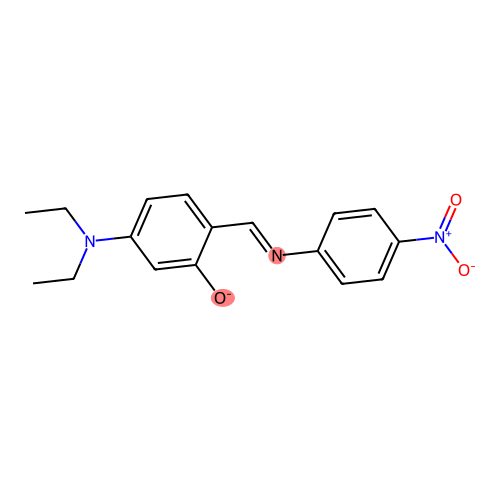

In [3]:
smiles = 'CCN(CC)c1ccc(/C=N/c2ccc([N+](=O)[O-])cc2)c([O-])c1'
predicted_coordinating_atoms = [10, 21]
save_image_path='example_ligand.png'
analyze.visualize(smiles=smiles, coord_atoms=predicted_coordinating_atoms, save_image_path=save_image_path)

### Step 4: Using both coordination models synergistically
While both the coordination number and coordinating atoms models exhibit high accuracy when used independently, performance can be further improved by using the models together to further learn from one another. Consider for example the ligand represented by SMILES `Oc1ccccc1CN(Cc1[c]cccc1)Cc1ccccc1P(c1ccccc1)c1ccccc1`. The coordination number model predicts this ligand to be tetradentate with a coordination number of 4, while the coordinating atoms model predicts only 3 total coordinating atoms:

    predicted_coordination_number: 4
    predicted_coordinating_atoms: [8, 11, 23]
    predicted_coordinating_atoms_symbols: [N, C, P]

We know physically that the number of coordinating atoms must be equal to the coordination number, so at least one of these predictions must be incorrect. We can enforce consistency between the two model predictions by overwriting the less confident prediction. But how do we determine which model is less confident in its prediction?

To determine the less confident prediction, we introduce the notion of prediction uncertainty, which we define as the maximum difference between an absolute prediction of 0 or 1 for all predictions generated by a given model on a given ligand. For example, for SMILES `Oc1ccccc1CN(Cc1[c]cccc1)Cc1ccccc1P(c1ccccc1)c1ccccc1`, the uncertainty in coordination number is readily determined from the prediction probabilities:

    coordination_number_probabilities: [0.0009476863779127598, 0.01018285658210516, 0.15256823599338531, 0.8276102542877197, 0.007166680879890919, 0.0015243253437802196]
    coordination_number_uncertainties: [0.0009476863779127598, 0.01018285658210516, 0.15256823599338531, 0.17238974571228027, 0.007166680879890919, 0.0015243253437802196]
    coordination_number_uncertainty: 0.17238974571228027

Identical logic is applied to determine uncertainty in predicted coordinating atoms, resulting in:

    coordinating_atoms_uncertainties: 0.38589248061180115

After calculating uncertainty for each prediction on each ligand, the predictions are compared to ensure the predicted coordination number is equal to the sum of predicted coordinating atoms. If not, consistency is enforced by overwriting the more uncertain prediction. If the predicted coordinating atoms are more uncertain than the predicted coordination number, we return only the top $N$ coordinating atom predictions, where $N$ is the predicted coordination number. Similarly, if predicted coordination number is more uncertain, we overwrite this prediction with the total number of predicted coordinating atoms.

In the case of our example ligand SMILES `Oc1ccccc1CN(Cc1[c]cccc1)Cc1ccccc1P(c1ccccc1)c1ccccc1`, since the coordinating atoms model is more uncertain, we overwrite this prediction to enforce internal consistency. This results in the correction of a previously incorrect prediction, further improving model performance ([CSD entry 'DIYPAG'](https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIYPAG&DatabaseToSearch=Published)):

    predicted_coordination_number: 4
    new_predicted_coordinating_atoms: [0, 8, 11, 23]
    new_predicted_coordinating_atoms_symbols: [O, N, C, P]

We recommend synergistic use of both coordination models as the default use of pydentate.

In [4]:
analyze.enforce_consistent_predictions(coordination_number_path='coordination_number_preds.csv',
                                       coordinating_atoms_path='coordinating_atoms_preds.csv', smiles_column='smiles')

Internal consistency enforced. 16 predictions updated.


### Conclusion
This concludes the pydentate tutorial. The predicted metal-ligand coordination may be used as inputs for further machine learning models, cheminformatics, or high throughout structure generation using software such as [molSimplify](https://github.com/hjkgrp/molSimplify).